In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/importance-sampling


In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import prepare_embeddings, summarize_all_metrics, summarize_all_deltas, summarize_all_mae, summarize_all_delta_mae
from src.utils.visualisation import plot_metric_bars, plot_pca_tripanel_hexbin, plot_pca_joint_kde, plot_two_panel_barplot


/Users/282066/Documents/PHD/Importance Sampling/importance-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set paths
DATA_PATH = "data/processed/cv_combined.pkl"

In [5]:
# Load data
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 111624 rows


In [6]:
# Inspect structure
df["source"].value_counts()

source
fairface    88211
utk         23413
Name: count, dtype: int64

### Intra dataset check

In [7]:
# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['age_gt'] < 20)
               ].sample(frac=0.4, random_state=0)

df_source = df[df["source"].str.contains("utk")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 21634 samples
Target: 1779 samples


In [8]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'ethnicity_gt',
       'face_bg_contrast_L',
       'face_bg_contrast_A', 'face_bg_contrast_B', 'gender_r', 'age_r',
       'features_r', 'gender_m', 'age_m', 'features_m', 'arcface_embedding',
       'gender_m_int'
]

Current best logistic target prob avg at iter 1: 0.150


<Axes: title={'center': 'ita'}, xlabel='ita', ylabel='Density'>

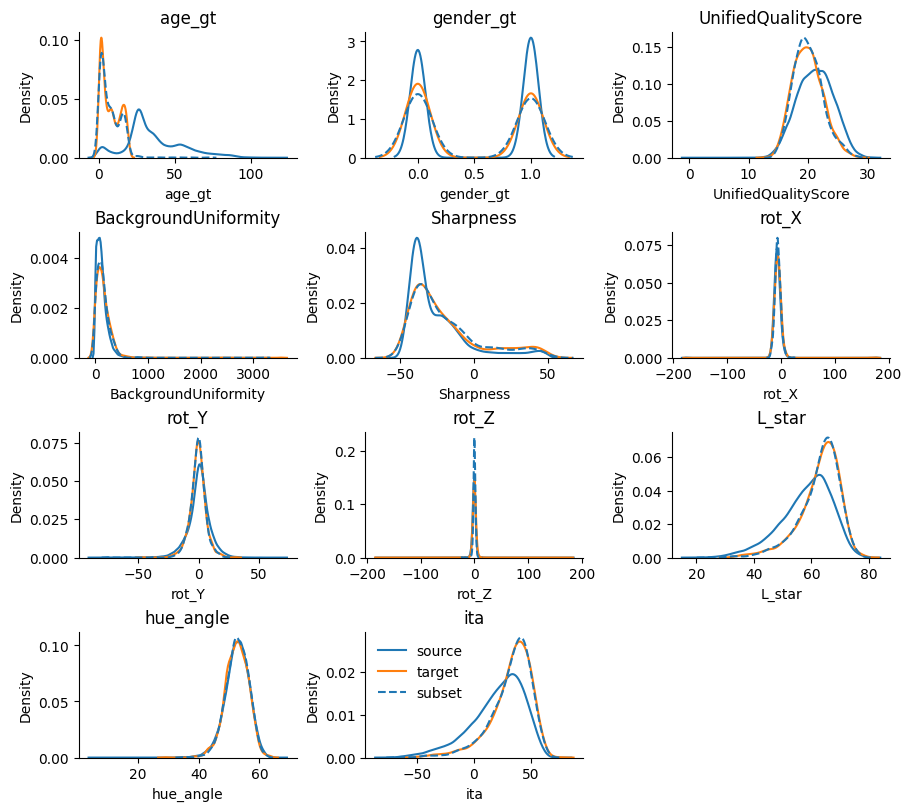

In [9]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3)

In [10]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_1 = summarize_all_metrics(datasets,
                                   label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df_1)

        set     metric      mean     lower     upper
0    Source  precision  0.939800  0.935268  0.944016
1    Source     recall  0.912442  0.907363  0.917518
2    Target  precision  0.828876  0.790695  0.864367
3    Target     recall  0.392476  0.358823  0.423545
4    Sample  precision  0.844407  0.791444  0.889363
5    Sample     recall  0.382676  0.342849  0.422254
6  Weighted  precision  0.841976  0.808406  0.873019
7  Weighted     recall  0.416336  0.382682  0.447372


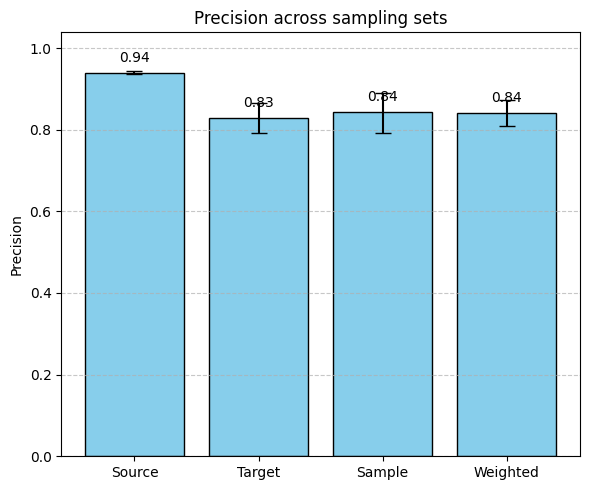

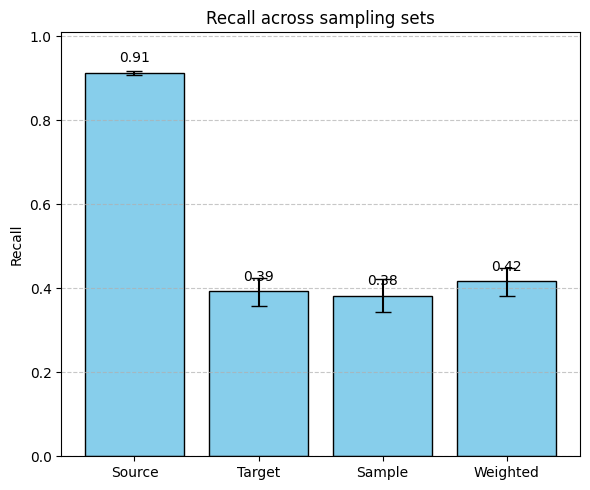

In [11]:
# Plot metrics
plot_metric_bars(results_df_1, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_1, metric="recall", title="Recall across sampling sets")

### Age estimation

In [12]:
# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['age_gt'] >50)].sample(frac=0.4, random_state=42)

df_source = df[df["source"].str.contains("utk")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 21585 samples
Target: 1828 samples


In [13]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'ethnicity_gt',
       'face_bg_contrast_L',
       'face_bg_contrast_A', 'face_bg_contrast_B', 'gender_r', 'age_r',
       'features_r', 'gender_m', 'age_m', 'features_m', 'arcface_embedding',
]

Current best logistic target prob avg at iter 1: 0.148


<Axes: title={'center': 'gender_m_int'}, xlabel='gender_m_int', ylabel='Density'>

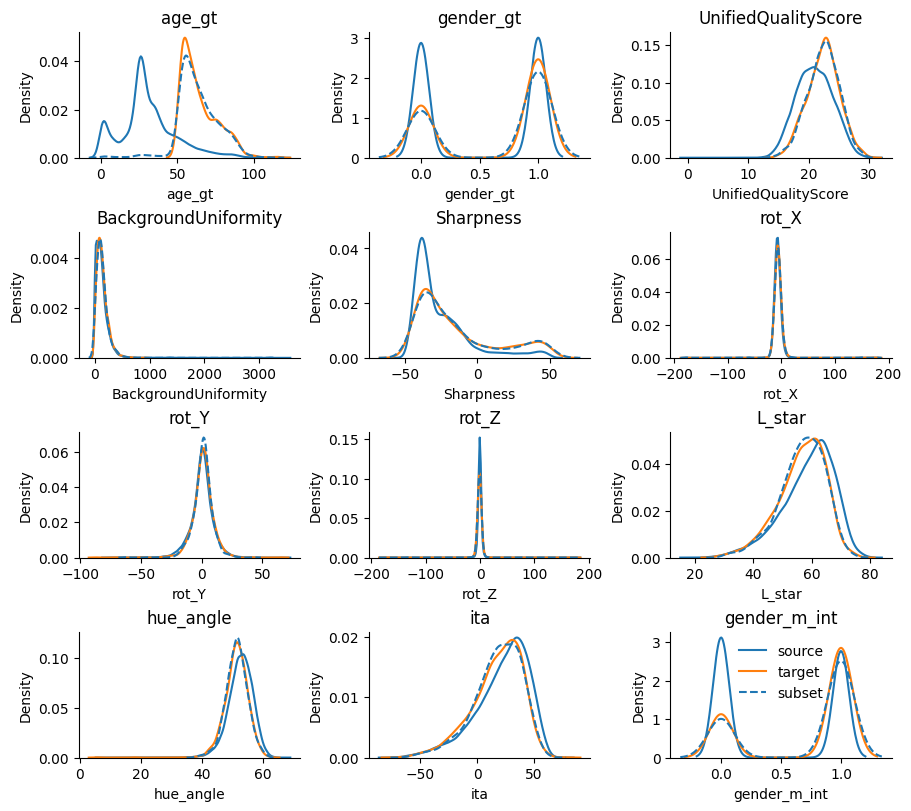

In [14]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3)

In [15]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_mae(datasets, label_col='age_gt', pred_col='age_m', n_bootstrap=1000)
print(results_df)

        set metric       mean      lower      upper
0    Source    MAE   6.197995   6.123914   6.276317
1    Target    MAE  12.997814  12.585833  13.398556
2    Sample    MAE  12.441849  11.920571  12.982797
3  Weighted    MAE  12.526923  12.130028  12.937798


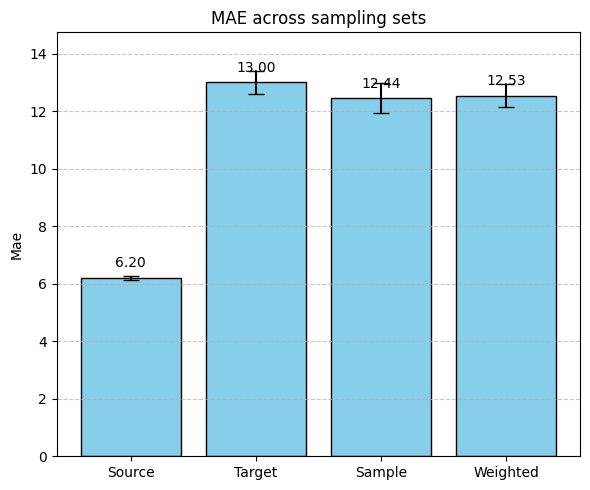

In [16]:
# Plot metrics
plot_metric_bars(results_df, metric="MAE", title="MAE across sampling sets")

### Cross dataset

In [17]:
df = pd.read_pickle(DATA_PATH)

# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['age_gt'] <20)
                # & (df['ethnicity_gt'] == 'Asian')
               ]

df_source = df[df["source"].str.contains("fairface")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 88211 samples
Target: 4448 samples


In [18]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'ethnicity_gt',
       'face_bg_contrast_L',
       'face_bg_contrast_A', 'face_bg_contrast_B', 'gender_r', 'age_r',
       'features_r', 'gender_m', 'age_m', 'features_m', 'arcface_embedding',
]

Current best logistic target prob avg at iter 1: 0.084


<Axes: title={'center': 'gender_m_int'}, xlabel='gender_m_int', ylabel='Density'>

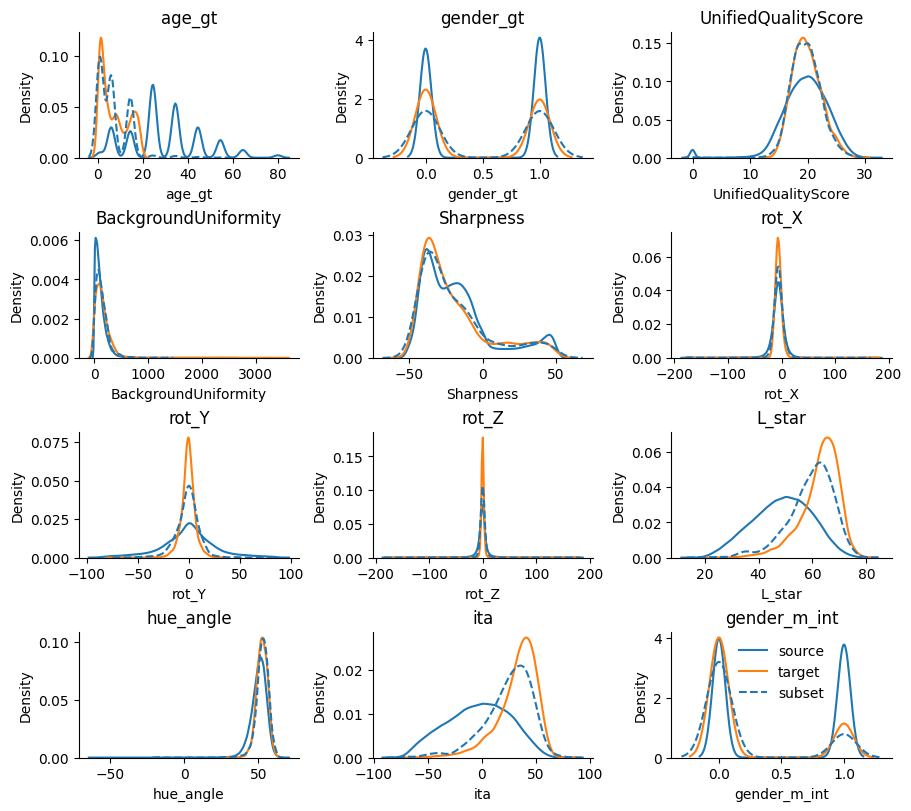

In [19]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3)

In [20]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_2 = summarize_all_metrics(datasets, label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df_2)

        set     metric      mean     lower     upper
0    Source  precision  0.904340  0.901595  0.907172
1    Source     recall  0.840413  0.837158  0.843851
2    Target  precision  0.823571  0.798056  0.847024
3    Target     recall  0.393915  0.373955  0.416238
4    Sample  precision  0.806413  0.746114  0.859158
5    Sample     recall  0.318693  0.277445  0.359843
6  Weighted  precision  0.780589  0.744319  0.814462
7  Weighted     recall  0.302415  0.279106  0.326154


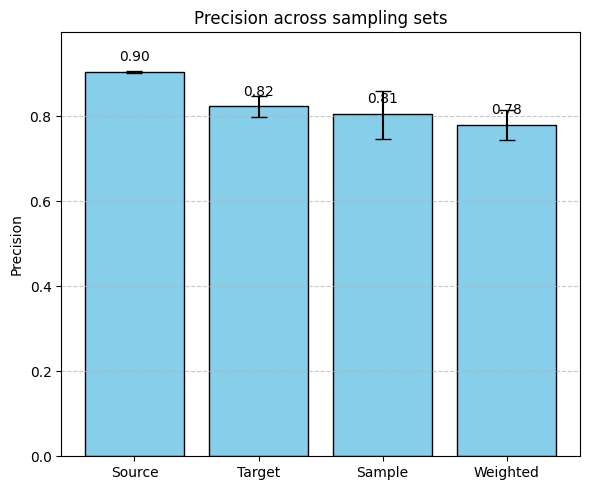

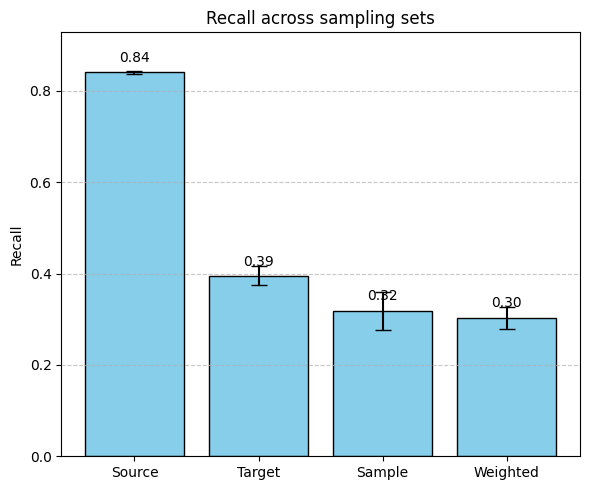

In [21]:
# Plot metrics
plot_metric_bars(results_df_2, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_2, metric="recall", title="Recall across sampling sets")

### Model-internal features 

In [22]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "features_m"  # or "features_r" or "arcface_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=10)


Applying PCA to reduce from 384 to 10 dimensions...
Total variance explained by 10 components: 97.79%


In [23]:
# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['age_gt'] <20)
             # & (df['ethnicity_gt'] == 'Asian')
               ] 
df_source = df[df["source"].str.contains("fairface")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 88211 samples
Target: 4448 samples


In [24]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'age_gt', 'gender_gt', 'ethnicity_gt', 'UnifiedQualityScore', 'BackgroundUniformity',
    'Sharpness', 'rot_X', 'rot_Y', 'rot_Z', 'L_star','hue_angle', 'ita', 'face_bg_contrast_L', 'face_bg_contrast_A',
    'face_bg_contrast_B', 'gender_r', 'age_r', 'features_r', 'gender_m', 'gender_m_int','age_m','features_m', 'arcface_embedding',
]

Current best logistic target prob avg at iter 1: 0.083


<Axes: title={'center': 'pca_9'}, xlabel='pca_9', ylabel='Density'>

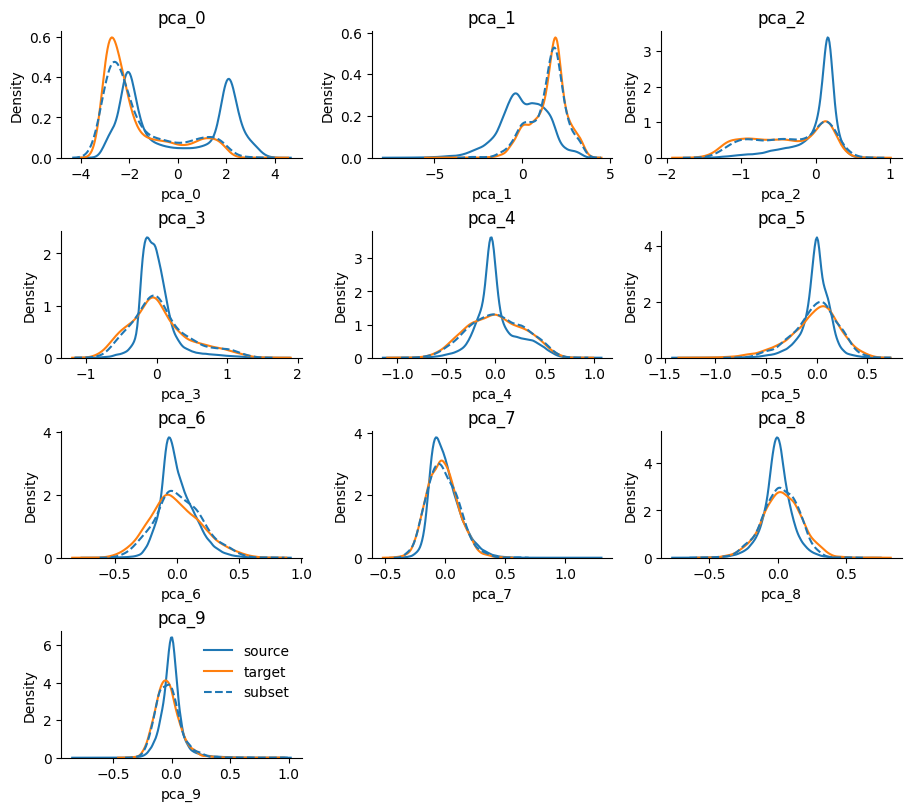

In [25]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3)

In [30]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_3 = summarize_all_metrics(datasets, label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df_3)

        set     metric      mean     lower     upper
0    Source  precision  0.904340  0.901595  0.907172
1    Source     recall  0.840413  0.837158  0.843851
2    Target  precision  0.823571  0.798056  0.847024
3    Target     recall  0.393915  0.373955  0.416238
4    Sample  precision  0.785706  0.732785  0.835344
5    Sample     recall  0.428703  0.384603  0.474160
6  Weighted  precision  0.810946  0.798051  0.822996
7  Weighted     recall  0.425970  0.413027  0.439370


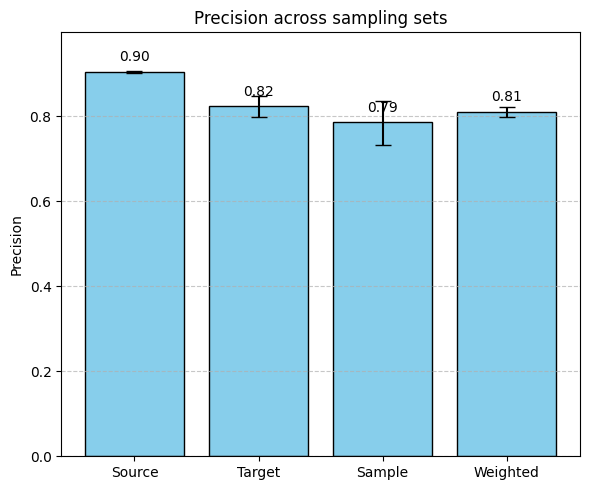

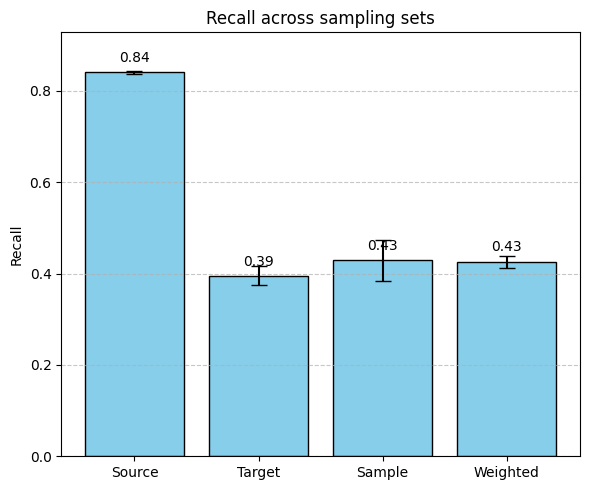

In [31]:
# Plot metrics
plot_metric_bars(results_df_3, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_3, metric="recall", title="Recall across sampling sets")

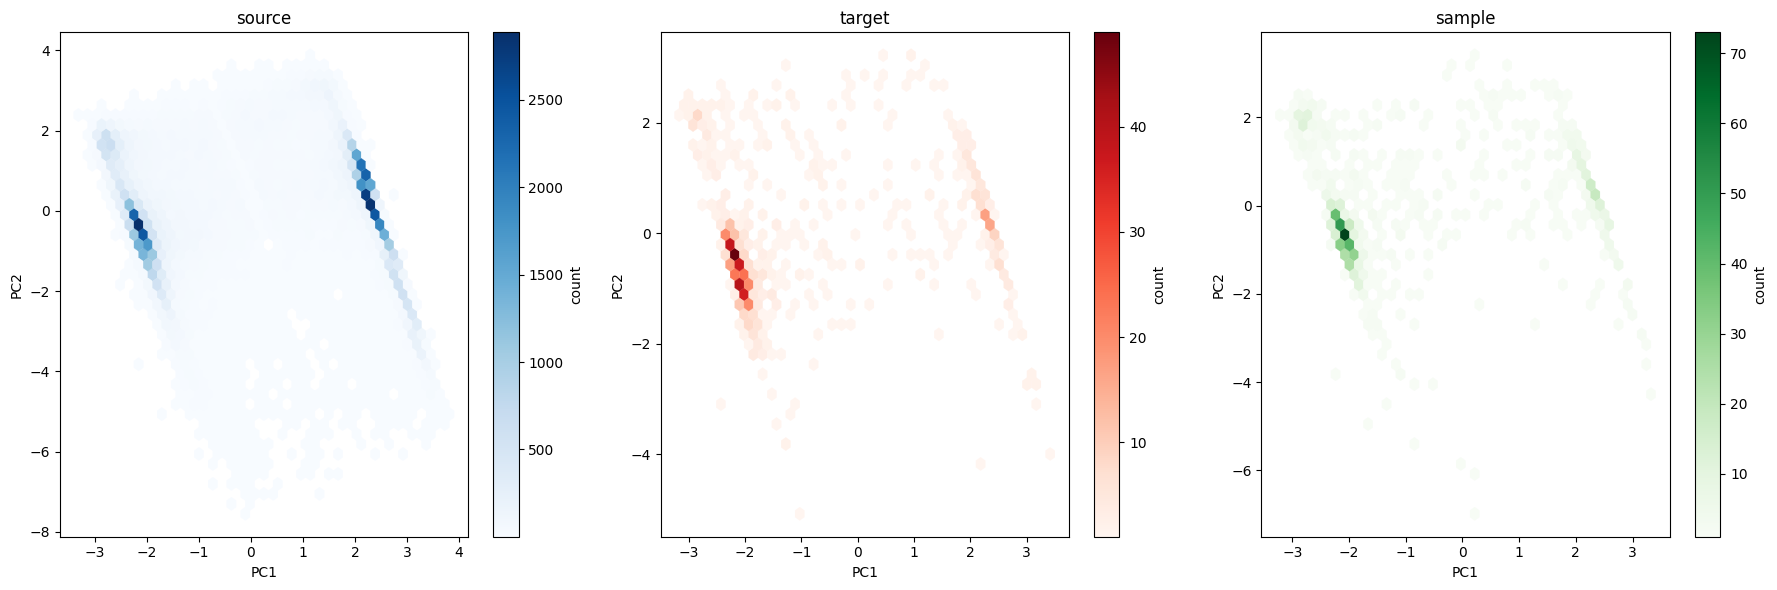

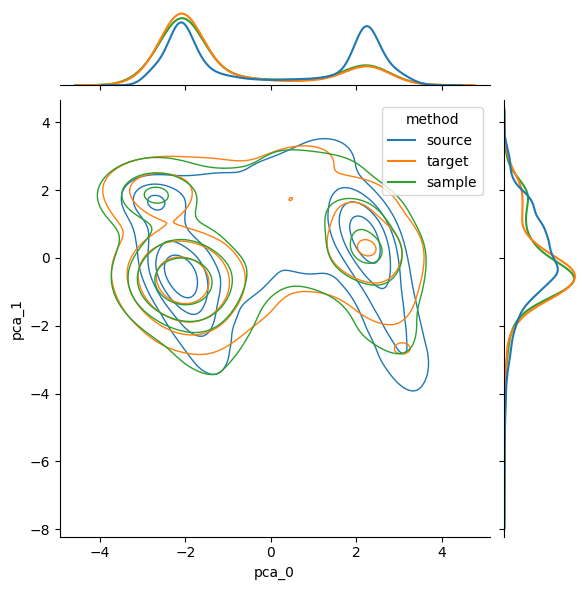

In [52]:
plot_pca_tripanel_hexbin(df_source, df_target, df_sample, ignore_cols=ignore_columns)
plot_pca_joint_kde(df_source, df_target, df_sample, ignore_cols = ignore_columns)

### General face embedding 

In [130]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "arcface_embedding"  # or "features_r" or "arcface_embedding"
use_pca = False  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca)


Using full embedding of size 512...


In [131]:
# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['age_gt'] <20)
             # & (df['ethnicity_gt'] == 'Asian')
               ] 
df_source = df[df["source"].str.contains("fairface")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 88211 samples
Target: 4448 samples


In [132]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'age_gt', 'gender_gt', 'ethnicity_gt', 'UnifiedQualityScore', 'BackgroundUniformity',
    'Sharpness', 'rot_X', 'rot_Y', 'rot_Z', 'L_star','hue_angle', 'ita', 'face_bg_contrast_L', 'face_bg_contrast_A',
    'face_bg_contrast_B', 'gender_r', 'age_r', 'features_r', 'gender_m', 'gender_m_int','age_m','features_m', 'arcface_embedding',
]

In [133]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
# imp.plot(df_sample, maxcols=3)

Current best logistic target prob avg at iter 1: 0.030


In [134]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_4 = summarize_all_metrics(datasets, label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df_4)

        set     metric      mean     lower     upper
0    Source  precision  0.904340  0.901595  0.907172
1    Source     recall  0.840413  0.837158  0.843851
2    Target  precision  0.823571  0.798056  0.847024
3    Target     recall  0.393915  0.373955  0.416238
4    Sample  precision  0.907117  0.877103  0.933831
5    Sample     recall  0.746469  0.707563  0.783308
6  Weighted  precision  0.903918  0.899988  0.907963
7  Weighted     recall  0.751996  0.744574  0.758983


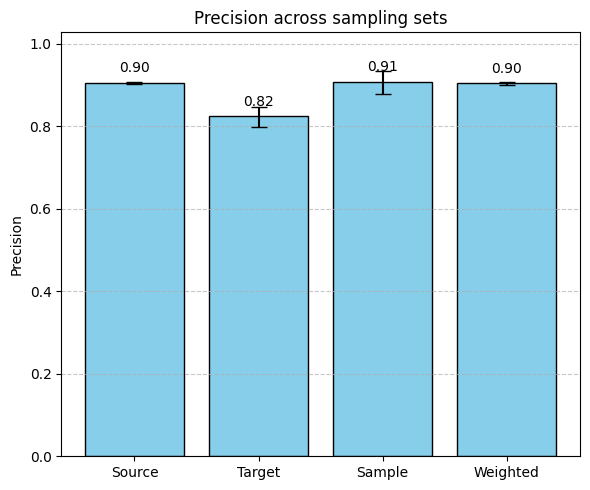

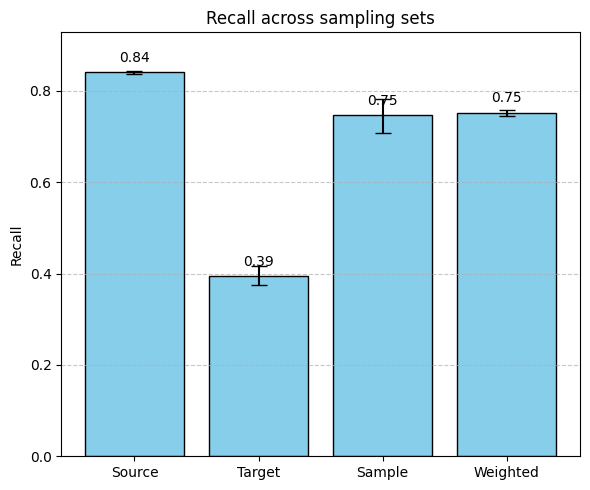

In [135]:
# Plot metrics
plot_metric_bars(results_df_4, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_4, metric="recall", title="Recall across sampling sets")

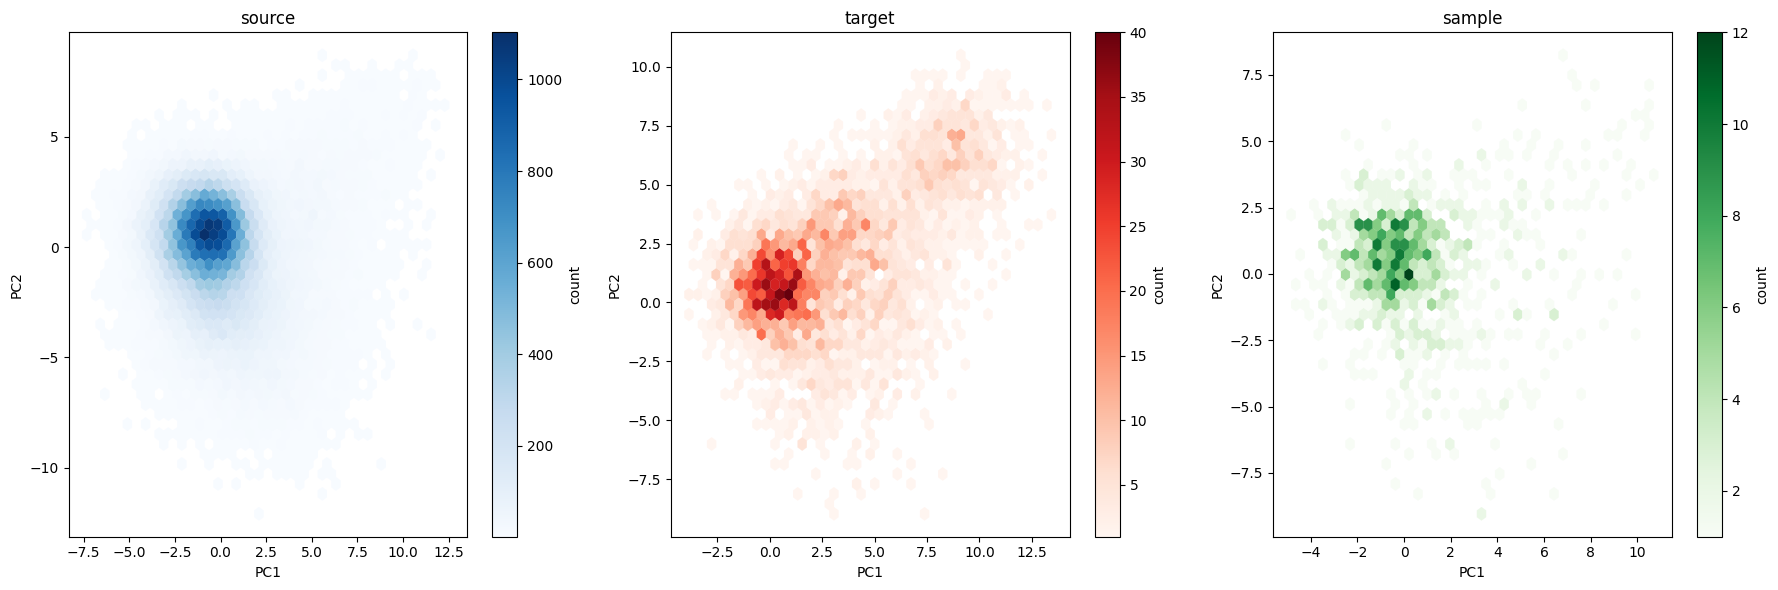

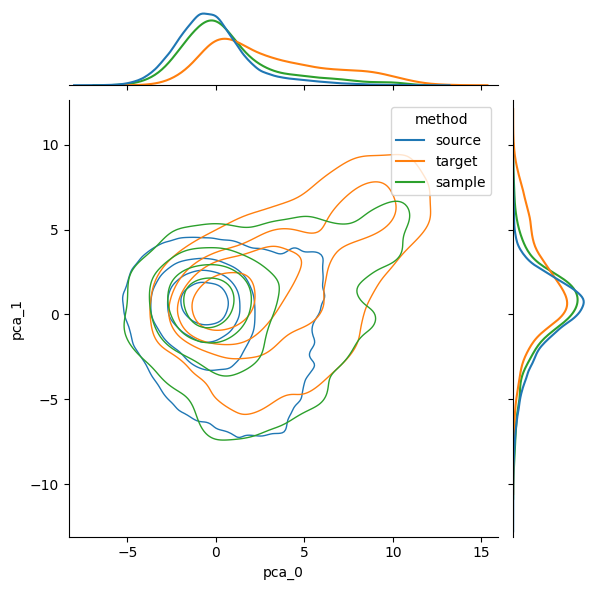

In [136]:
plot_pca_tripanel_hexbin(df_source, df_target, df_sample, ignore_cols=ignore_columns)
plot_pca_joint_kde(df_source, df_target, df_sample, ignore_cols = ignore_columns)

### Shift in qualityscore

In [62]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "features_m"  # or "features_r" or "arcface_embedding"
use_pca = False  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=5)


Using full embedding of size 384...


In [63]:
# Define domains
df_target = df[df["source"].str.contains("utk") 
               & (df['UnifiedQualityScore'] <16) ]
df_source = df[df["source"].str.contains("fairface")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 88211 samples
Target: 938 samples


In [64]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'age_gt', 'gender_gt', 'ethnicity_gt', 'UnifiedQualityScore', 'BackgroundUniformity',
    'Sharpness', 'rot_X', 'rot_Y', 'rot_Z', 'L_star','hue_angle', 'ita', 'face_bg_contrast_L', 'face_bg_contrast_A',
    'face_bg_contrast_B', 'gender_r', 'age_r', 'features_r', 'gender_m','age_m','features_m', 'arcface_embedding',
]

In [65]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)

Current best logistic target prob avg at iter 1: 0.028


In [66]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_5 = summarize_all_metrics(datasets, label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df_4)

        set     metric      mean     lower     upper
0    Source  precision  0.904340  0.901595  0.907172
1    Source     recall  0.840413  0.837158  0.843851
2    Target  precision  0.823571  0.798056  0.847024
3    Target     recall  0.393915  0.373955  0.416238
4    Sample  precision  0.907117  0.877103  0.933831
5    Sample     recall  0.746469  0.707563  0.783308
6  Weighted  precision  0.903918  0.899988  0.907963
7  Weighted     recall  0.751996  0.744574  0.758983


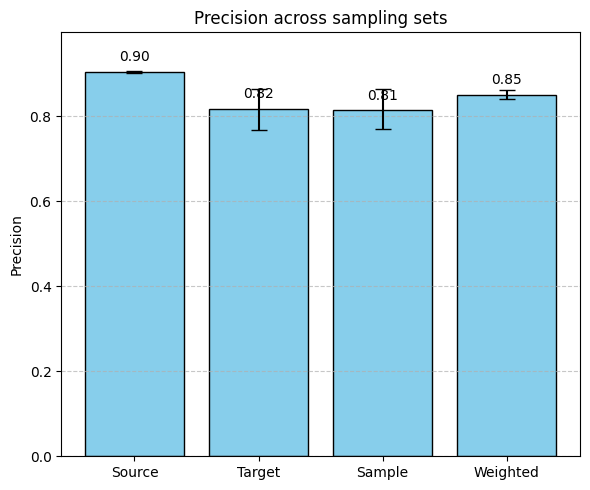

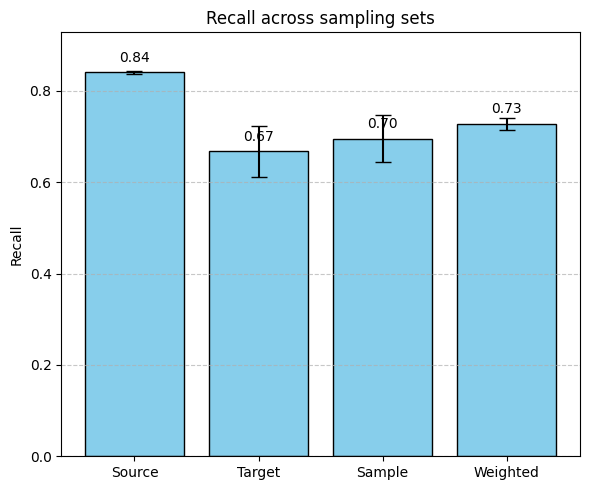

In [67]:
# Plot metrics
plot_metric_bars(results_df_5, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df_5, metric="recall", title="Recall across sampling sets")

### Summarize results 

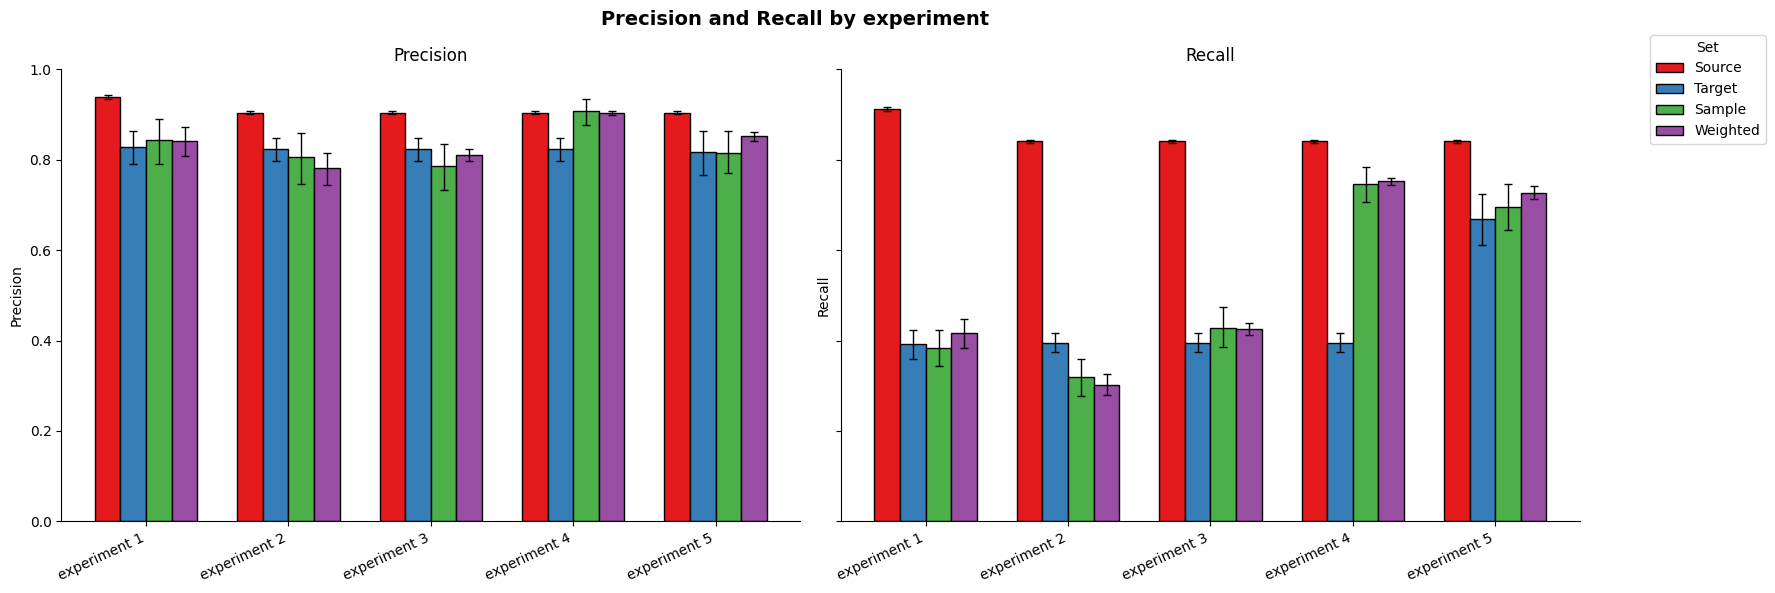

In [98]:
results = {
    "Known shift intra dataset - explicit features weighting": results_df_1,
    "Cross dataset shift - explicit features weighting": results_df_2,
    "Cross dataset shift - model internal weighting": results_df_3,
    "Cross dataset shift - arcface face embeddings": results_df_4,
    "Cross dataset shift quality score - model internal features": results_df_5

}

results = {
    "experiment 1": results_df_1,
    "experiment 2": results_df_2,
    "experiment 3": results_df_3,
    "experiment 4": results_df_4,
    "experiment 5": results_df_5,

}

plot_two_panel_barplot(
    results)
plt.show()


### Fairness regression 

In [149]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "features_m"  # or "features_r" or "arcface_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=10)


Applying PCA to reduce from 384 to 10 dimensions...
Total variance explained by 10 components: 97.79%


In [150]:
# Define domains
df_target_m = df[df["source"].str.contains("utk") & 
                 (df['gender_gt'] == 0) & 
                 (df['age_gt'] > 30)]
df_target_f = df[df["source"].str.contains("utk") & (df['gender_gt'] == 1)]
df_target = pd.concat([
    df_target_m.sample(n=300, random_state =42),
    df_target_f.sample(n=300, random_state =42)
]).reset_index(drop=True)

df_source = df[df["source"].str.contains("utk")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 22813 samples
Target: 600 samples


In [151]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'age_gt', 'gender_gt', 'ethnicity_gt', 'UnifiedQualityScore', 'BackgroundUniformity',
    'Sharpness', 'rot_X', 'rot_Y', 'rot_Z', 'L_star','hue_angle', 'ita', 'face_bg_contrast_L', 'face_bg_contrast_A',
    'face_bg_contrast_B', 'gender_r', 'age_r', 'features_r', 'gender_m', 'gender_m_int','age_m','features_m', 'arcface_embedding',
] 

Current best logistic target prob avg at iter 1: 0.041


<Axes: title={'center': 'pca_9'}, xlabel='pca_9', ylabel='Density'>

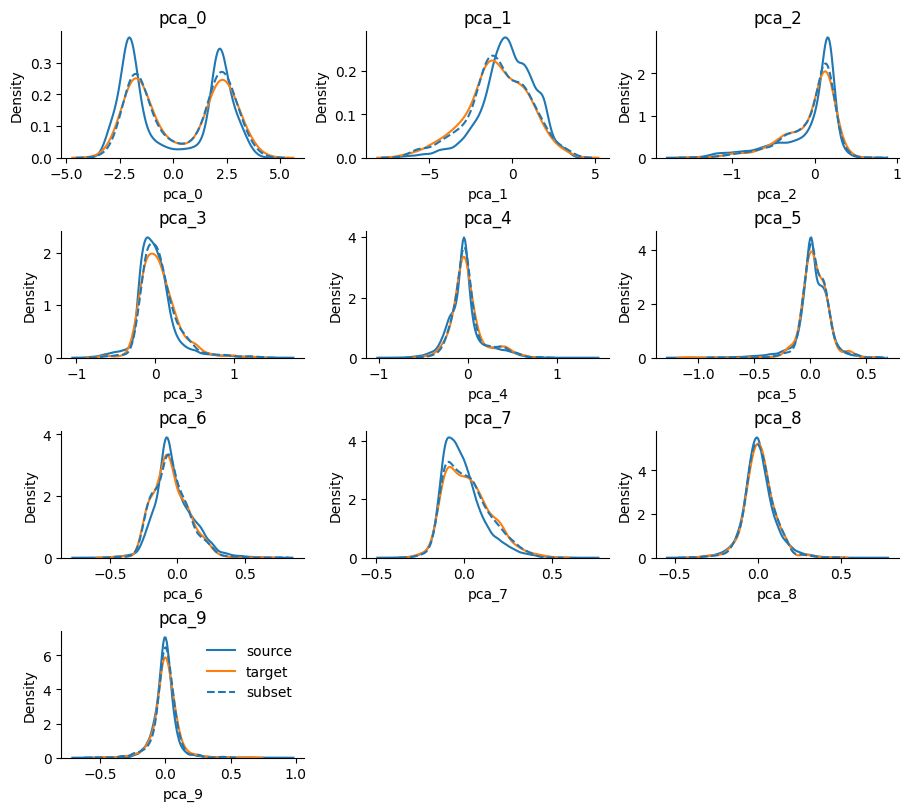

In [152]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3) 

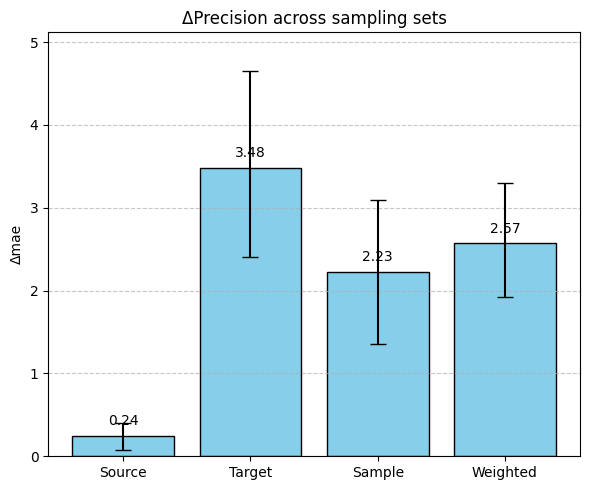

In [154]:
# Compute bootstrap metric differences vs Target
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_delta_mae(datasets, 
                                    group_col="gender_gt",
                                    group_a=0,
                                    group_b=1,
                                    label_col="age_gt",
                                    pred_col="age_m",
                                    n_bootstrap=1000)

# Plot metrics
plot_metric_bars(results_df, metric="ΔMAE", title="ΔPrecision across sampling sets")


### Fairness UTKFaces versus FairFace

In [137]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "features_m"  # or "features_r" or "arcface_embedding"
use_pca = False  # toggle between full embedding or PCA

# df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=5)


In [138]:
# Define domains
df_target = df[df["source"].str.contains("fairface") 
               ]

df_source = df[df["source"].str.contains("utk")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 23413 samples
Target: 88211 samples


In [143]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'ethnicity_gt',
        'gender_r', 'age_r',
       'features_r', 'gender_m', 'age_m', 'features_m', 'arcface_embedding',
       'gender_m_int'
]

Current best logistic target prob avg at iter 1: 0.148


<Axes: title={'center': 'face_bg_contrast_B'}, xlabel='face_bg_contrast_B', ylabel='Density'>

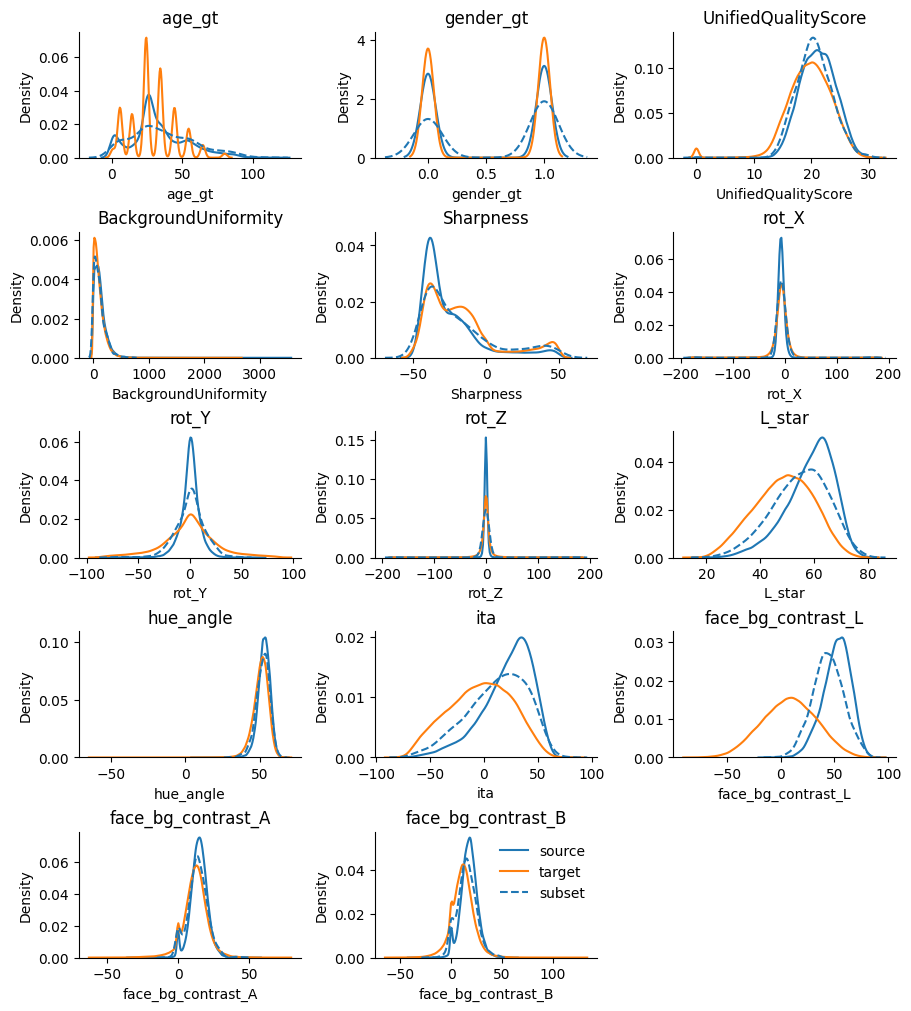

In [144]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3) 

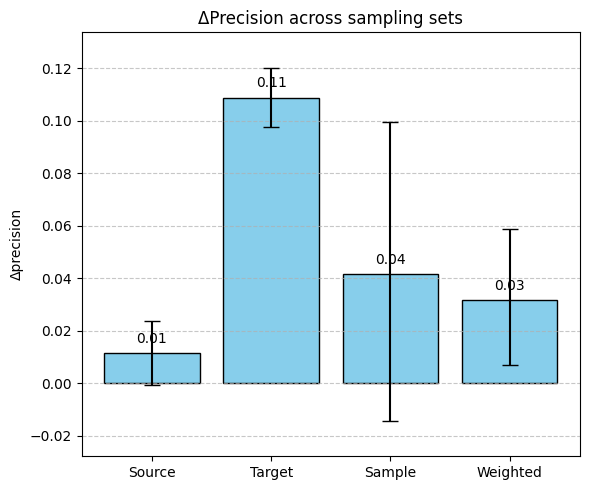

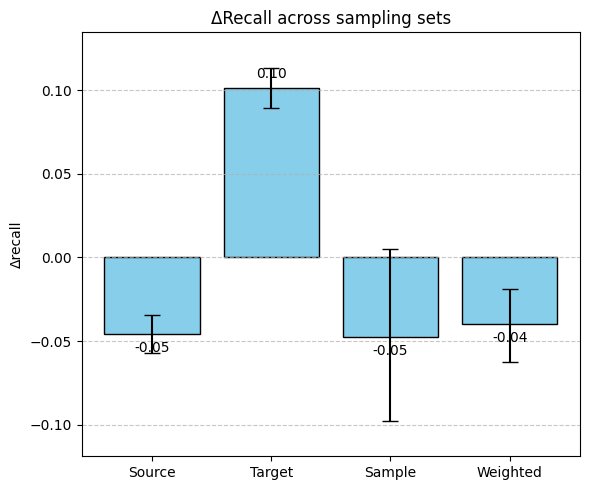

In [147]:
# Compute bootstrap metric differences vs Target
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_deltas(datasets, 
                                    group_col="ethnicity_gt",
                                    group_a='White',
                                    group_b='Black',
                                    label_col="gender_gt",
                                    pred_col="gender_m_int",
                                    n_bootstrap=1000)

# Plot metrics
plot_metric_bars(results_df, metric="Δprecision", title="ΔPrecision across sampling sets")
plot_metric_bars(results_df, metric="Δrecall", title="ΔRecall across sampling sets")

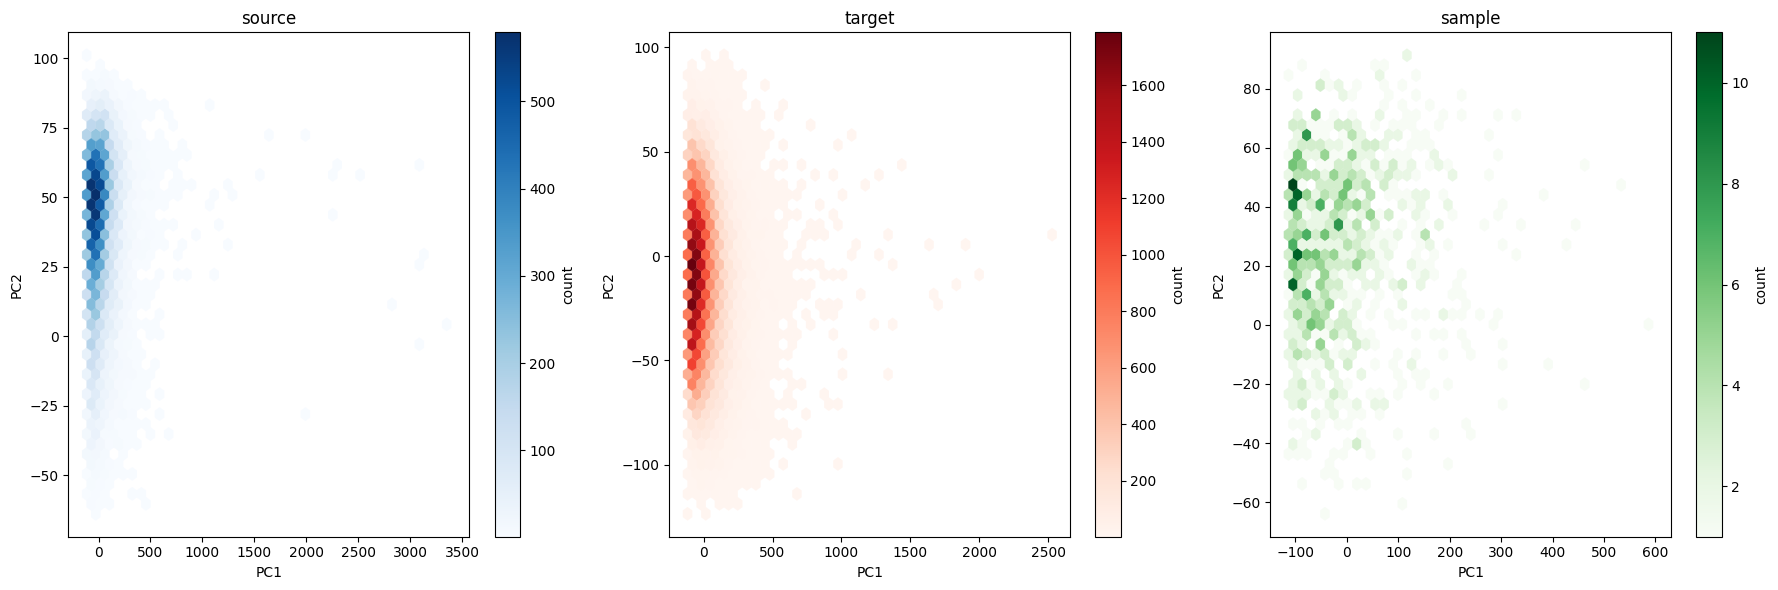

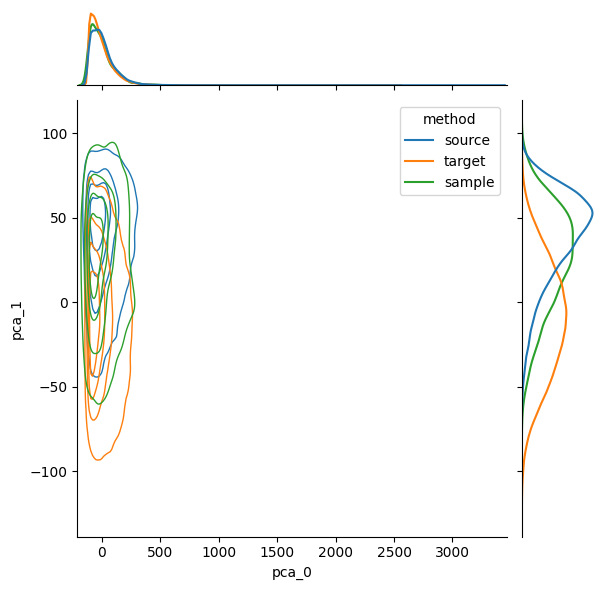

In [148]:
plot_pca_tripanel_hexbin(df_source, df_target, df_sample, ignore_cols=ignore_columns)
plot_pca_joint_kde(df_source, df_target, df_sample, ignore_cols = ignore_columns)

### Label shift

In [ ]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

df = pd.read_pickle(DATA_PATH)
features = "features_m"  # or "features_r" or "arcface_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=5)


Applying PCA to reduce from 384 to 5 dimensions...
Total variance explained by 5 components: 96.67%


In [ ]:
# Define domains

df_target_0 = df[df["source"].str.contains("fairface") & (df['gender_gt'] == 0 ) ]
df_target_1 = df[df["source"].str.contains("fairface") & (df['gender_gt'] == 1 ) ]
df_target = pd.concat([
    df_target_0.sample(n=1600, random_state =42),
    df_target_1.sample(n=400, random_state =42)
]).reset_index(drop=True)

# df_target = df[df["source"].str.contains("utk") & (df['age_gt'] > 75)]

df_source = df[df["source"].str.contains("fairface")
               & (~df['filename'].isin(df_target['filename']))]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

print(f"Source: {df_source['gender_gt'].mean():.2f} fraction males")
print(f"target: {df_target['gender_gt'].mean():.2f} fraction males")

Source: 86211 samples
Target: 2000 samples
Source: 0.53 fraction males
target: 0.20 fraction males


In [ ]:
n_components = 500
embeddings = [f'embedding_{i}' for i in range(n_components)]

n_components = 10
pca_components = [f'pca_{i}' for i in range(n_components)]

In [ ]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = [
    'filename', 'source', 'age_gt', 'gender_gt', 'ethnicity_gt', 'UnifiedQualityScore', 'BackgroundUniformity',
    'Sharpness', 'rot_X', 'rot_Y', 'rot_Z', 'L_star','hue_angle', 'ita', 'face_bg_contrast_L', 'face_bg_contrast_A',
    'face_bg_contrast_B', 'gender_r', 'age_r', 'features_r', 'gender_m', 'gender_m_int','age_m','features_m', 'arcface_embedding',
] + pca_components


In [ ]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, 
                                       attempts=N_ITERS,
                                       frac_y_1=0.2,
                                       label_col = 'gender_gt'
                                       )
# imp.plot(df_sample, maxcols=3) 

Current best logistic target prob avg at iter 1: 0.000


In [ ]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, label_col='gender_gt', pred_col='gender_m_int', n_bootstrap=1000)
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.906914  0.904091  0.909538
1    Source     recall  0.840506  0.837106  0.844025
2    Target  precision  0.673278  0.631576  0.715156
3    Target     recall  0.828076  0.789332  0.863184
4    Sample  precision  0.671556  0.611092  0.736113
5    Sample     recall  0.842521  0.788820  0.895607
6  Weighted  precision  0.682391  0.675184  0.689161
7  Weighted     recall  0.840506  0.837106  0.844025


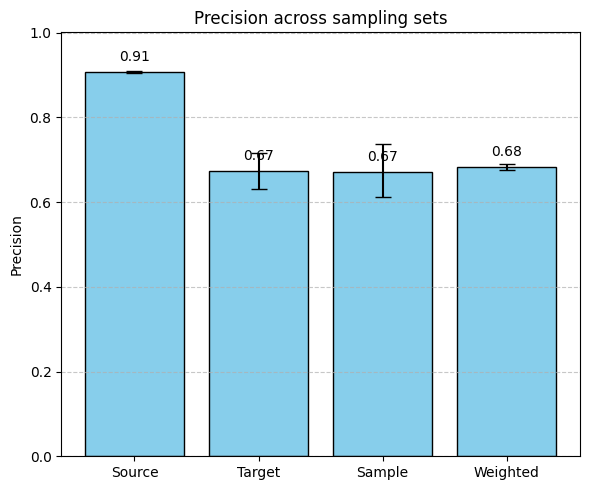

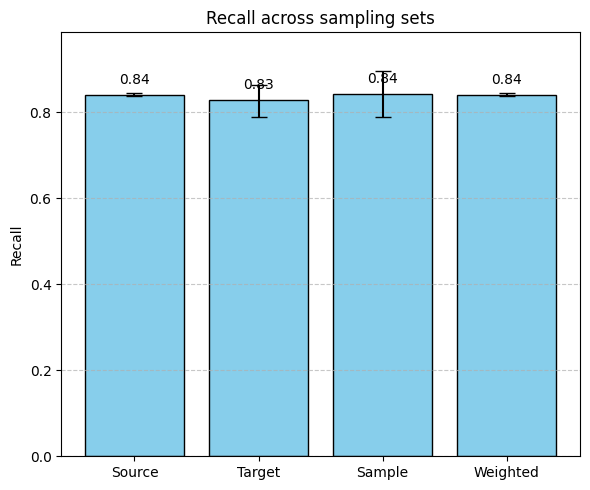

In [ ]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")